## Tianjie Zhang

# CS 534 Final Exam

Due 11:59 pm MDT, Friday, May 6, 2022


# Problem 1 (24 points)

**QUESTION**: Implement the Expectation Maximization (EM) algorithm for the  Gaussian Mixture Model in python.

### Create the dataset

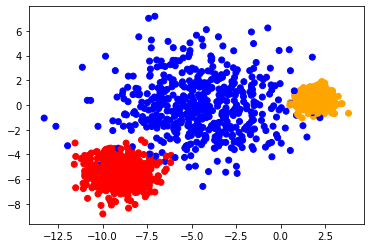

In [341]:
import numpy as np
import pandas as pd

#data
n_samples = 1500

varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
data=varied

color=['red','blue','orange','black', 'purple','pink']
X,y=data

plt.scatter(X[:,0], X[:,1],  c=np.array([color[x] for x in y] ))
plt.show()

#######



In [343]:
import numpy as np
import random

def prob_calculate(x,u,cov):
    cov_inv=np.linalg.inv(cov)
    cov_det=np.linalg.det(cov)
    return np.exp(-1/2*((x-u).T.dot(cov_inv.dot(x-u))))/np.sqrt(cov_det)


def gmm(x,k=2,epochs=100,reload_params=None):
    features_num=len(x[0])
    r=np.empty(shape=(len(x),k))

    if reload_params!=None:
        a,u,cov=reload_params
    else:
        a=np.random.uniform(size=k)
        a/=np.sum(a)
        u=np.array(random.sample(list(x),k))
        cov=np.empty(shape=(k,features_num,features_num))

        for i in range(k):
            for j in range(features_num):
                cov[i][j]=[0]*j+[0.5]+[0]*(features_num-j-1)
    step=0
    while step<epochs:

        for j in range(len(x)):
            for i in range(k):
                r[j,i]=a[i]*prob_calculate(x[j],u[i],cov[i])
            r[j]/=np.sum(r[j])
            
        for i in range(k):
            r_toal=np.sum(r[:,i])
            u[i]=np.sum([x[j]*r[j,i] for j in range(len(x))],axis=0)/r_toal
            cov[i]=np.sum([r[j,i]*((x[j]-u[i]).reshape((features_num,1)).dot((x[j]-u[i]).reshape((1,features_num)))) for j in range(len(x))],axis=0)/r_toal
            a[i]=r_toal/len(x)
        step+=1
    C=[]
    for i in range(k):
        C.append([])
    for j in range(len(x)):
        c_j=np.argmax(r[j,:])
        C[c_j].append(x[j])
    return C,a,u,cov



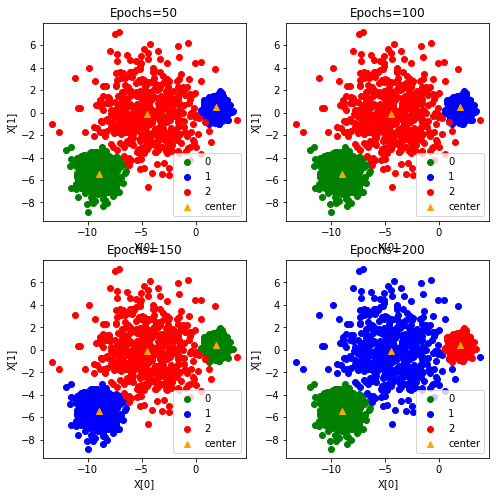

In [345]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,8))
for epochs in [1,2,3,4]:
    res,A,U,COV=gmm(x=X,k=3,epochs=epochs*50)

    plt.subplot(2,2,epochs)
    for i in range(len(res)):
        plt.scatter([d[0] for d in res[i]],[d[1] for d in res[i]],color=colors[i],label=str(i))
    plt.scatter([d[0] for d in U],[d[1] for d in U],color=colors[-1],marker='^',label='center')

    plt.xlabel('X[0]')
    plt.ylabel('X[1]')
    plt.title('Epochs='+str(epochs*50))
    plt.legend()

# Problem 2 (23 points)

**QUESTION**: Use with a dataset different from IRIS the following technique:

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html (scikit)

Explain why this technique is important.

### Here, I use the wine dataset in sklearn to use this technique.

In [208]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

wine = datasets.load_wine()
X=wine.data
y=wine.target

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
feature_names = [f"feature {i}" for i in range(X.shape[1])]
#feature_names = wine.target_names
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

In [209]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


Elapsed time to compute the importances: 0.020 seconds


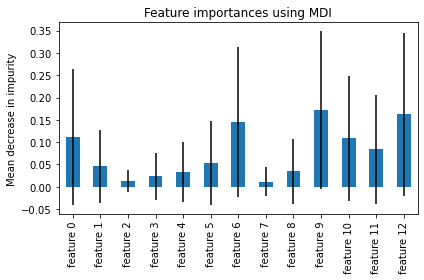

In [210]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [211]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)


Elapsed time to compute the importances: 2.786 seconds


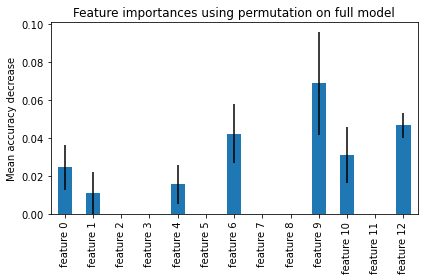

In [212]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#### The technique is important is because:

The permutation feature importance, which is defined to be the decrease in a model score when a single feature value is randomly shuffled, breaks the relationship between the feature and the target. The Mean accuracy decrease in the model is indicative of how much the model depends on the feature. 

Tree-based models can give high importance to features that may not be predictive on unseen data when the model is overfitting. Permutation-based feature importance, on the other hand, avoids this issue, since it can be computed on unseen data.

Based on this, we can use this technique to evaluate which feature or features are important to the final classification result so that we can give penalty to other features or give more importance to to these features.

Another motivation is to have not only an accurate model, but also an interpretable model, explaining the output of the model by being able to indicate which features are most important in determining the obseved model result.

# Problem 3 (23 points)

**QUESTION**: Compare by discussing results the technique in 2 with the coefficients (W) of the logistic regression. (scikit)

### I want to compare the values of the feature_importances_ from forest of trees and the coef_ from logistic regression to figure out the difference between them.

[ 0.44036482 -0.90696813  2.30849566  0.96232763]


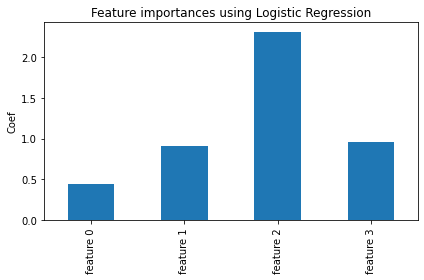

In [245]:
iris = datasets.load_iris()
X=iris.data[0:100]
y=iris.target[0:100]

from sklearn.linear_model import LogisticRegression
feature_names = [f"feature {i}" for i in range(X.shape[1])]
lr = LogisticRegression(solver='lbfgs')
lr.fit(X, y)
coef=lr.coef_
print(np.ravel(coef))

lr_parameters = pd.Series(abs(np.ravel(coef)), index=feature_names)


fig, ax = plt.subplots()
lr_parameters.plot.bar()
ax.set_title("Feature importances using Logistic Regression")
ax.set_ylabel("Coef")
fig.tight_layout()

### As we can see that, the  feature 3 have the largest coefficient in logistic regression.

[0.07654645 0.0480488  0.45911765 0.4162871 ]


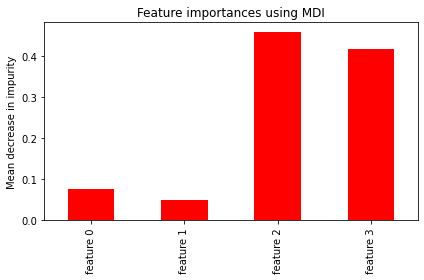

In [248]:
from sklearn.ensemble import RandomForestClassifier
feature_names = [f"feature {i}" for i in range(X.shape[1])]
#feature_names = wine.target_names
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
print(importances)
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(color='r')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### As we can see, the feature 2 and feature 3 have the most highest values.

# Problem 4 (12 points)

**QUESTION**: Describe the main differences between K-means and DB-Scan, use examples. (scikit)

Differences between K-means and DB_Scan:

1. The DB_Scan method can find the out-liers in datasets but the K-means method can't as seen in example 1.

2. The K-means method depends on the distance to the center point to cluster dataset while the DB-Scan uses density around the key point to cluster the dataset as we can see in example 2. The K means algorithm can not classify these moon-shape data because some data points in one single moon is longer than some data the other moon while the DB-Scan can classfy these easily because each moon-shape class is in high density.

3. K-means needs you to decide the number of clusters (parameter K) to start the cluster work while DB-Scan didn't, what you need to do in DB-Scan is make sure the radius (eps) and density (min_samples). DB-Scan is not a centroid based algorithm.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

### Example 1:

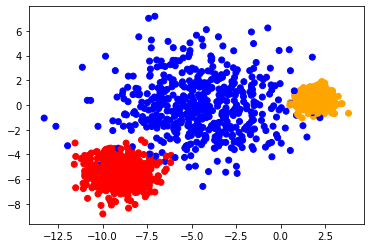

In [14]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), np.array([1 for x in range(n_samples)])

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
#data=aniso
data=varied
#data=noisy_moons
#data=noisy_circles
#data=blobs
color=['red','blue','orange','black', 'purple','pink']
X,y=data
plt.scatter(X[:,0], X[:,1],  c=np.array([color[x] for x in y] ))
plt.show()

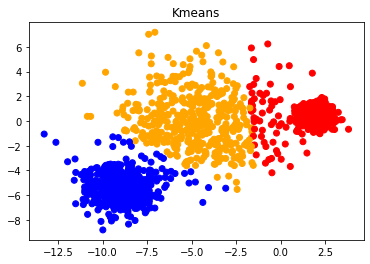

In [18]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=3, random_state=0).fit(X)
pred=clustering.predict(X)
plt.scatter(X[:,0], X[:,1],  c=np.array([color[x] for x in pred] ))
plt.title('Kmeans')
plt.show()

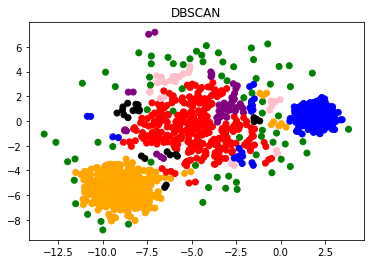

In [19]:
from sklearn.cluster import DBSCAN
pred = DBSCAN(eps=0.4, min_samples=2).fit_predict(X)

plt.scatter(X[:,0], X[:,1],  c=np.array([color[x%6] if x>=0 else 'green' for x in pred ] ))
plt.title('DBSCAN')
plt.show()

## Example 2:

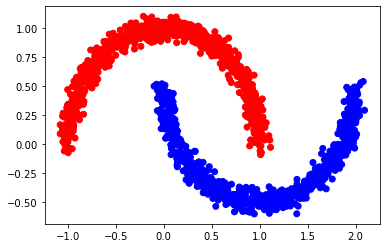

In [21]:
data=noisy_moons
color=['red','blue','orange','black', 'purple','pink']
X,y=data
plt.scatter(X[:,0], X[:,1],  c=np.array([color[x] for x in y] ))
plt.show()

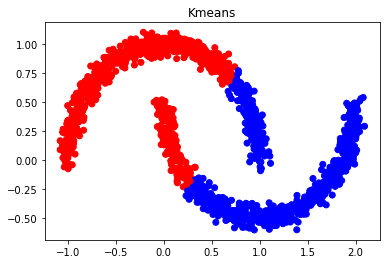

In [23]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=2, random_state=0).fit(X)
pred=clustering.predict(X)
plt.scatter(X[:,0], X[:,1],  c=np.array([color[x] for x in pred] ))
plt.title('Kmeans')
plt.show()

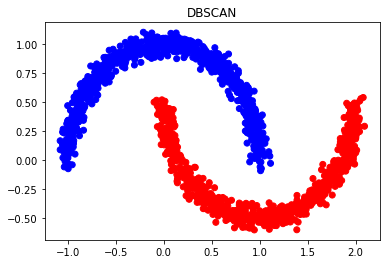

In [27]:
from sklearn.cluster import DBSCAN
pred = DBSCAN(eps=0.1, min_samples=4).fit_predict(X)

plt.scatter(X[:,0], X[:,1],  c=np.array([color[x%6] if x>=0 else 'green' for x in pred ] ))
plt.title('DBSCAN')
plt.show()

# Problem 5 (24 points)

**QUESTION**: Implement a procedure to estimate the optimal number of clusters in the k-Means and Gaussian mixture model (try to differentiate the two procedures). (scikit)

### In my view, if there is a certain practical meaning in choosing the number of clusters, it would be better to choose one which has the actual meaning in real life. For example, a child poured three color candy on the ground, and you want to cluster the candy on the ground. It would be a good idea to use three as the number of clusters rather than to calculate the silhouettes or BIC(or AIC). Of course, if you do not have a very clear idea of the data set, the silhouettes or BIC(or AIC) index can be a wise choose to help us define the optimal number of clusters.

### For the K-Means:

In [53]:

wine = datasets.load_wine()
X=wine.data
y=wine.target
from sklearn.metrics import silhouette_score
silhouettes=[]
K = range(2,6)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    silhouettes.append(silhouette_score(X,kmeanModel.predict(X)))
silhouettes

[0.6568536504294317,
 0.5711381937868838,
 0.5620323449580341,
 0.5489993239795675]

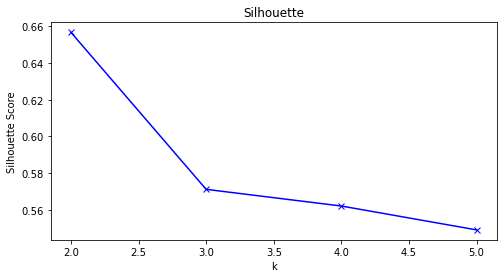

In [54]:
plt.figure(figsize=(8,4))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette')
plt.show()

### The optimum classes for this wine dataset is 3.

## Gaussian mixture model

Text(0.5, 0, 'n_components')

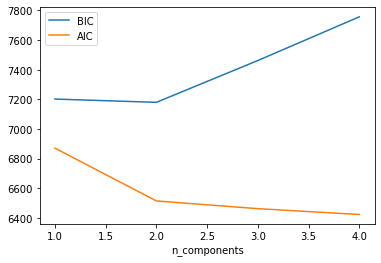

In [52]:
from sklearn.mixture import GaussianMixture as GMM
n_components = np.arange(1, 5)
models = [GMM(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

### The plot shows that  2  classes might be the best choise.

# Problem 6 (24 points)

**QUESTION**: Implement the algorithm of hierarchical clustering with maximum or complete linkage 

(this can help www.econ.upf.edu/~michael/stanford/maeb7.pdf)

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
iris = datasets.load_iris()
X=iris.data
#y=iris.target

from sklearn.preprocessing import normalize
data_scaled = normalize(X)

data_scaled1 = pd.DataFrame(data_scaled)
data_scaled1.head(10)

#data_scaled['class']=y

,0,1,2,3
0,0.803773,0.551609,0.220644,0.031521
1,0.828133,0.507020,0.236609,0.033801
2,0.805333,0.548312,0.222752,0.034269
3,0.800030,0.539151,0.260879,0.034784
4,0.790965,0.569495,0.221470,0.031639
5,0.784175,0.566349,0.246870,0.058087
6,0.780109,0.576603,0.237425,0.050877
7,0.802185,0.545486,0.240655,0.032087
8,0.806424,0.531507,0.256589,0.036656
9,0.818031,0.517530,0.250418,0.016695


In [203]:
class Hierarchical:
    def __init__(self, data, k):
        self.k = k #how many classes you want to have
        self.dataset = data 
        self.heap = []
        self.cluster = []
        
        
    
    
    def distance(self, x, y):
        
        #The iris data has 4 features
        
        dist=np.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2+(x[2]-y[2])**2+(x[3]-y[3])**2)
    
        return dist
        
    def checkdata(self, *args):
        #get all the points
        result = []
        for value in args:
            if isinstance(value, tuple):
                result += self.checkdata(*value)
            else:
                result.append(value)
        return tuple(result)
    

    def comp_linkage(self, pair): 
        
        pt = []
        
        dist_list = []
        
        pt = self.checkdata(pair)
  
        for i in range(len(pt) - 1):
        
            for j in range(i+1, len(pt)):
                
                dist_list.append((self.distance(self.dataset[pt[i],:], self.dataset[pt[j],:]), pair))
  
        return max(dist_list)
    
    def compute_pairwise_distance(self, list_data): 

        results = []

        dataset_size = len(list_data)

        for i in range(dataset_size-1):   

            for j in range(i+1, dataset_size): 
                if isinstance(list_data[i], int) and isinstance(list_data[j], int): 
                    dist = (self.distance(self.dataset[list_data[i],:], self.dataset[list_data[j],:]), 
                                    (list_data[i], list_data[j]))
                else:
                    dist = self.comp_linkage((list_data[i], list_data[j]))
                    
                results.append(dist)
        
        return results
    
        
    def H_cluster(self):
        
        self.cluster = list(range(self.dataset.shape[0]))#first step
        
        while len(self.cluster) > self.k:
            
            list_distances = min(self.compute_pairwise_distance(self.cluster))
            self.cluster.remove(list_distances[1][0])
            self.cluster.remove(list_distances[1][1])
            self.cluster.append(list_distances[1]) # Merge the most similar data points
        
        return [("data point "+str(clusteer)+"--> The Cluster "+ str(i)) for i, clusteer in enumerate(self.cluster)]
    
    




In [204]:
#decide how many classes you want to have. here is 6.
cluster = Hierarchical(data_scaled,6)

In [205]:
cluster.H_cluster()

['data point 41--> The Cluster 0',
 'data point ((32, (22, (16, (15, 33)))), ((14, (35, 36)), (((5, 21), (46, (6, 19))), ((37, (4, 42)), (13, ((48, (2, (0, 10))), (17, 40)))))))--> The Cluster 1',
 'data point (((25, (1, ((20, 34), (9, 12)))), ((28, 49), (31, 45))), ((24, 44), ((43, (23, 26)), ((30, (3, 8)), ((11, 29), ((47, (7, 38)), (18, (27, 39))))))))--> The Cluster 2',
 'data point ((((141, 145), ((110, (127, 138)), ((112, 147), (123, (126, 139))))), ((((117, 137), (124, 149)), (103, (83, 116))), (((102, 111), (135, 146)), ((125, 133), (72, 129))))), (((70, (66, 84)), (85, (56, 59))), (((77, (53, 54)), ((86, 97), (52, 89))), (((88, 95), ((78, (91, 94)), ((96, 99), (51, 61)))), (73, (131, (90, (55, 63))))))))--> The Cluster 3',
 'data point (((114, ((136, 148), (100, (106, 121)))), (((128, (113, 132)), (143, (104, (101, 142)))), ((120, 140), (144, (109, 115))))), (134, (118, ((119, 130), ((108, 122), (105, 107))))))--> The Cluster 4',
 'data point (((68, 87), (62, (60, 76))), ((64,